In [2]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable


In [3]:

all_sample=pd.read_csv("all_sample.csv",encoding='utf-8')
all_sample['ans'] = all_sample['ans'].str.replace("wrong","not_fit")
negative_data=all_sample[all_sample["ans"]=="not_fit"]
postive_data=all_sample[all_sample["ans"]=="fit"]


#訓練2500 測試500+500
train_P=postive_data.sample(7015,random_state=178)
train_N=negative_data.sample(2985,random_state=198)
test_P=train_P.sample(1400,random_state=73)
test_N=train_N.sample(575,random_state=65)

train_P=train_P.drop(test_P.index)
train_N=train_N.drop(test_N.index)

train_P=train_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
train_N=train_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_P=test_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_N=test_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)

In [4]:
transform2=transforms.Compose([
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #标准化至[-1,1]
])

batch_size=64

train_dir = "train"           
#定義數據集
train_datasets = datasets.ImageFolder(train_dir, transform=transform2)
#加載數據集
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

In [5]:
class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        net = models.resnet18(pretrained=False)
        net.fc = nn.Sequential()
        self.model = net
        # 鎖定 ResNet18 預訓練模型參數
        #for param in self.model.parameters():
        #    param.requires_grad = False

        # 修改輸出層輸出數量
        self.fc = nn.Sequential(
            nn.Linear(512, 64),
            nn.Linear(64, 2)
        )
        

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
model = ResNet().to("cuda")

c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
model

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.tensor(alpha)
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = (1 - pt) ** self.gamma * CE_loss

        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            focal_loss = self.alpha[targets] * focal_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [9]:
optimizer = optim.Adam(model.parameters(), lr=5e-5)

loss_func = FocalLoss()

In [62]:
# 損失函數
loss_func = nn.CrossEntropyLoss()

# 學習優化器
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)#5的負2次方

In [10]:
epoch=30

if torch.cuda.is_available():
    model.cuda()


model.train()

loss_list = []
accuracy_list = []
tr_loss_list = []
tr_accuracy_list = []

for i in range(epoch):
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    pbar=tqdm(total=len(train_dataloader))
    for img, label in train_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss.item()
        pred = torch.max(output, 1)[1]
        train_correct = (pred == label).sum()
        train_acc += train_correct.item()
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()

    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_datasets)), train_acc / (len(train_datasets))))
    tr_loss_list.append(train_loss / (len(train_datasets)))
    tr_accuracy_list.append(100 * train_acc / (len(train_datasets)))
    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    #混淆矩陣要用得list
    y_true=[]
    y_pred=[]
    for img, label in val_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        out = model(img)
        loss = loss_func(out, label)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
        
        #混淆矩陣要用的
        y_true.extend(label.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))
    loss_list.append(eval_loss / (len(val_datasets)))
    accuracy_list.append(100 * eval_acc / (len(val_datasets)))

epoch 1


100%|██████████| 126/126 [00:36<00:00,  3.44it/s]


Train Loss: 0.000947, Acc: 0.611963
Test Loss: 0.000782, Acc: 0.721013
epoch 2


100%|██████████| 126/126 [00:23<00:00,  5.35it/s]


Train Loss: 0.001162, Acc: 0.493956
Test Loss: 0.000964, Acc: 0.506329
epoch 3


100%|██████████| 126/126 [00:23<00:00,  5.38it/s]


Train Loss: 0.000814, Acc: 0.714268
Test Loss: 0.000739, Acc: 0.728101
epoch 4


100%|██████████| 126/126 [00:23<00:00,  5.36it/s]


Train Loss: 0.000652, Acc: 0.802118
Test Loss: 0.000665, Acc: 0.794430
epoch 5


100%|██████████| 126/126 [00:23<00:00,  5.40it/s]


Train Loss: 0.000551, Acc: 0.838754
Test Loss: 0.000699, Acc: 0.761519
epoch 6


100%|██████████| 126/126 [00:23<00:00,  5.31it/s]


Train Loss: 0.000489, Acc: 0.863427
Test Loss: 0.000624, Acc: 0.837468
epoch 7


100%|██████████| 126/126 [00:23<00:00,  5.27it/s]


Train Loss: 0.000391, Acc: 0.898442
Test Loss: 0.000686, Acc: 0.862785
epoch 8


100%|██████████| 126/126 [00:23<00:00,  5.42it/s]


Train Loss: 0.000355, Acc: 0.906293
Test Loss: 0.000717, Acc: 0.843544
epoch 9


100%|██████████| 126/126 [00:23<00:00,  5.37it/s]


Train Loss: 0.000336, Acc: 0.910031
Test Loss: 0.000853, Acc: 0.860253
epoch 10


100%|██████████| 126/126 [00:23<00:00,  5.42it/s]


Train Loss: 0.000318, Acc: 0.915888
Test Loss: 0.000694, Acc: 0.842025
epoch 11


100%|██████████| 126/126 [00:23<00:00,  5.37it/s]


Train Loss: 0.000251, Acc: 0.938193
Test Loss: 0.000763, Acc: 0.855190
epoch 12


100%|██████████| 126/126 [00:23<00:00,  5.42it/s]


Train Loss: 0.000253, Acc: 0.934206
Test Loss: 0.000875, Acc: 0.813165
epoch 13


100%|██████████| 126/126 [00:23<00:00,  5.28it/s]


Train Loss: 0.000213, Acc: 0.947290
Test Loss: 0.001084, Acc: 0.862785
epoch 14


100%|██████████| 126/126 [00:23<00:00,  5.44it/s]


Train Loss: 0.000200, Acc: 0.948287
Test Loss: 0.000972, Acc: 0.864304
epoch 15


100%|██████████| 126/126 [00:23<00:00,  5.42it/s]


Train Loss: 0.000154, Acc: 0.962368
Test Loss: 0.000819, Acc: 0.849114
epoch 16


100%|██████████| 126/126 [00:23<00:00,  5.41it/s]


Train Loss: 0.000144, Acc: 0.965732
Test Loss: 0.001538, Acc: 0.867342
epoch 17


100%|██████████| 126/126 [00:23<00:00,  5.39it/s]


Train Loss: 0.000117, Acc: 0.970343
Test Loss: 0.001367, Acc: 0.849620
epoch 18


100%|██████████| 126/126 [00:23<00:00,  5.44it/s]


Train Loss: 0.000148, Acc: 0.962368
Test Loss: 0.001647, Acc: 0.866329
epoch 19


100%|██████████| 126/126 [00:23<00:00,  5.40it/s]


Train Loss: 0.000132, Acc: 0.967975
Test Loss: 0.001754, Acc: 0.867848
epoch 20


100%|██████████| 126/126 [00:23<00:00,  5.42it/s]


Train Loss: 0.000129, Acc: 0.971340
Test Loss: 0.001563, Acc: 0.856203
epoch 21


100%|██████████| 126/126 [00:23<00:00,  5.47it/s]


Train Loss: 0.000096, Acc: 0.978442
Test Loss: 0.001476, Acc: 0.858228
epoch 22


100%|██████████| 126/126 [00:22<00:00,  5.48it/s]


Train Loss: 0.000110, Acc: 0.973458
Test Loss: 0.001214, Acc: 0.845570
epoch 23


100%|██████████| 126/126 [00:23<00:00,  5.43it/s]


Train Loss: 0.000093, Acc: 0.979190
Test Loss: 0.001452, Acc: 0.838987
epoch 24


100%|██████████| 126/126 [00:22<00:00,  5.50it/s]


Train Loss: 0.000057, Acc: 0.988162
Test Loss: 0.001730, Acc: 0.863797
epoch 25


100%|██████████| 126/126 [00:23<00:00,  5.43it/s]


Train Loss: 0.000077, Acc: 0.984299
Test Loss: 0.001838, Acc: 0.870380
epoch 26


100%|██████████| 126/126 [00:22<00:00,  5.54it/s]


Train Loss: 0.000067, Acc: 0.985421
Test Loss: 0.001524, Acc: 0.836456
epoch 27


100%|██████████| 126/126 [00:23<00:00,  5.46it/s]


Train Loss: 0.000084, Acc: 0.980436
Test Loss: 0.001408, Acc: 0.840506
epoch 28


100%|██████████| 126/126 [00:22<00:00,  5.49it/s]


Train Loss: 0.000067, Acc: 0.985421
Test Loss: 0.001410, Acc: 0.862278
epoch 29


100%|██████████| 126/126 [00:22<00:00,  5.49it/s]


Train Loss: 0.000071, Acc: 0.985171
Test Loss: 0.001908, Acc: 0.866835
epoch 30


100%|██████████| 126/126 [00:22<00:00,  5.52it/s]


Train Loss: 0.000046, Acc: 0.989907
Test Loss: 0.002462, Acc: 0.860253


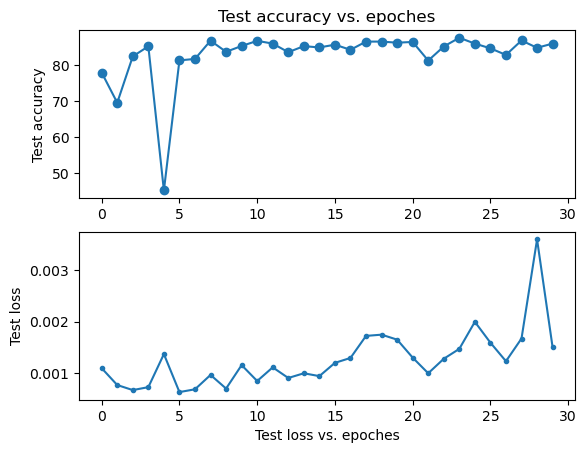

In [ ]:
import matplotlib.pyplot as plt

x1 = range(0, 30)
x2 = range(0, 30)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


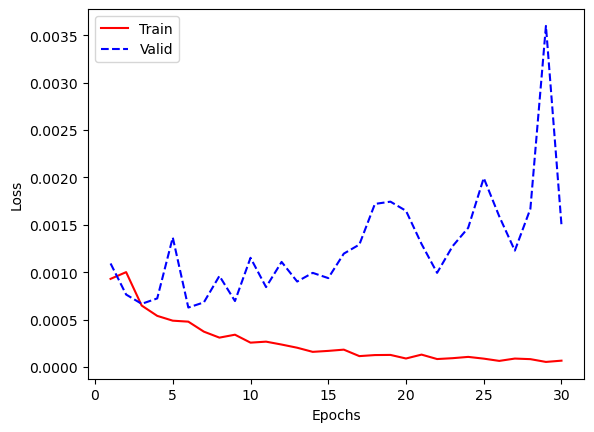

In [ ]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(30)]
plt.plot(epochs,tr_loss_list, color='red', label='Train')
plt.plot(epochs,loss_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

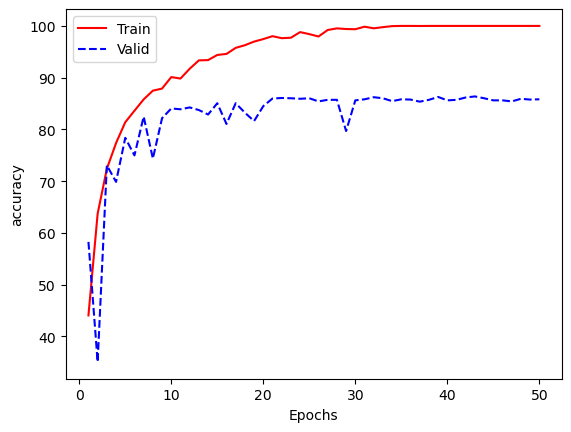

In [ ]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(30)]
plt.plot(epochs,tr_accuracy_list, color='red', label='Train')
plt.plot(epochs,accuracy_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

In [ ]:
torch.save(model.state_dict(), "Resnet18_98_86.pt")


In [ ]:
#混淆矩陣
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

In [ ]:

tp=cm[0][0]
fn=cm[0][1]
fp=cm[1][0]
tn=cm[1][1]
print("Accuracy:",(tp+tn)/(tp+fn+fp+tn) )

p_presicion=tp/(tp+fp)
p_recall=tp/(tp+fn)
print('FIT precision:',p_presicion)
print('FIT recall:',p_recall)

n_presicion=tn/(tn+fn)
n_recall=tn/(fp+tn)
print('n_FIT precision:',n_presicion)
print('n_FIT recall:',n_recall)

print("F1",(2*p_presicion*p_recall)/(p_presicion+p_recall))

Accuracy: 0.8288101265822785
FIT precision: 0.9012924193182678
FIT recall: 0.8517857142857143
n_FIT precision: 0.6816996471851511
n_FIT recall: 0.7728695652173913
F1 0.8758400352539385


[0.         0.14821429 1.        ] [0.         0.77286957 1.        ] [2 1 0]


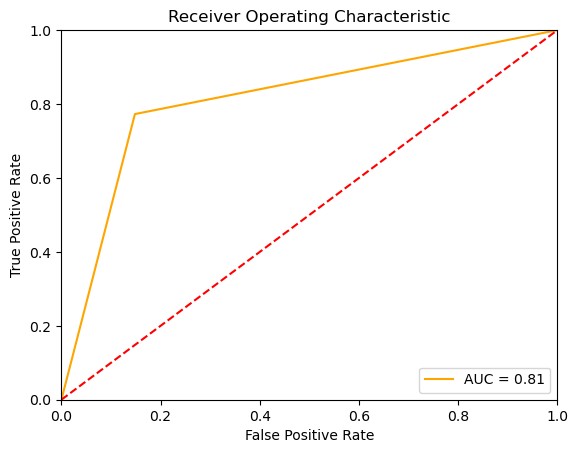

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_true, y_pred)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    